In [3]:
import os
import numpy as np
import glob
from tqdm import tqdm
import copy
from skimage.feature import canny
from skimage.transform import resize
import pandas as pd
import seaborn as sns
import SimpleITK as sitk
import nibabel as nib
# from torchinfo import summary

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchio as tio
from dataloader import RadOncTrainingDataset, RadOncValidationDataset, headscanner_training_dataset, headscanner_validation_dataset
import networks_gan
import losses
from skimage.metrics import structural_similarity as ssim

import surface_distance
from helpers import compute_surface_metrics, compute_TRE
os.environ['VXM_BACKEND'] = 'pytorch'
import voxelmorph as vxm  # nopep8

import matplotlib.pyplot as plt
from matplotlib import colors as mplcolors
from matplotlib.collections import LineCollection

def colormap_binary(fg, bg=(0,0,0), alpha=None):
    fg = mplcolors.to_rgb(fg)
    bg = mplcolors.to_rgb(bg)
    cmap = mplcolors.LinearSegmentedColormap.from_list('Binary', (bg,fg), 256)
    if alpha is not None:
        cmap._init()
        cmap._lut[:,-1] = np.linspace(0, alpha, cmap.N+3)
    return cmap
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use('dark_background')

2023-08-04 18:17:44.239316: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-04 18:17:44.435499: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-04 18:17:44.439410: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-04 18:17:44.439424: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

## Defining registration function

In [4]:
def command_iteration(method):
    print(
        f"{method.GetOptimizerIteration():3}"+f"{method.GetMetricValue():10.5f}"+f"{method.GetOptimizerPosition()}"
    )

In [5]:
def registration(fixed, moving):

    numberOfBins = 50
    samplingPercentage = 0.01

    tx = sitk.CenteredTransformInitializer(
        fixed, moving, sitk.Euler3DTransform(),sitk.CenteredTransformInitializerFilter.GEOMETRY)
    # sitk.WriteTransform(tx, "euler2D_initial.tfm")


    R = sitk.ImageRegistrationMethod()
    pixelType = sitk.sitkFloat32

    R.SetMetricAsCorrelation()

    R.SetOptimizerAsRegularStepGradientDescent(
        learningRate=1.0,
        minStep=1e-6,
        numberOfIterations=500,
        gradientMagnitudeTolerance=1e-8,
    )
    R.SetOptimizerScalesFromPhysicalShift()

    R.SetInitialTransform(tx)



    ##some tricks
    R.SetMetricAsMattesMutualInformation(numberOfBins)
    R.SetShrinkFactorsPerLevel([4,2,1])
    R.SetSmoothingSigmasPerLevel( [4,2,1] )
    R.SetMetricSamplingPercentage(samplingPercentage, sitk.sitkWallClock)
    R.SetMetricSamplingStrategy(R.RANDOM)
    # R.SetOptimizerAsRegularStepGradientDescent(5.0, 0.001, 500)
    # R.SetInitialTransform(sitk.TranslationTransform(fixed.GetDimension()))
    R.SetInterpolator(sitk.sitkLinear)

    #R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R))

    outTx = R.Execute(fixed, moving)

##  whether to save the transformation
#     sitk.WriteTransform(outTx, "euler2D.tfm")

    if "SITK_NOSHOW" not in os.environ:
        resampler = sitk.ResampleImageFilter()
        resampler.SetReferenceImage(fixed)
        resampler.SetInterpolator(sitk.sitkLinear)
        # resampler.SetDefaultPixelValue(1)
        resampler.SetDefaultPixelValue(0)

        resampler.SetTransform(outTx)

        out = resampler.Execute(moving)
        simg1 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
        simg2 = sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8)
    return simg2, outTx

In [6]:
def dataread(data_dict):
    fixed_img = data_dict['fixed_img']
    moving_img = data_dict['moving_img']
    fixed_warp = data_dict['fixed_warp']
    moving_truth = data_dict['moving_truth']
    ventricle_fixed = data_dict['ventricle_fixed']
    ventricle_moving = data_dict['ventricle_moving']
    affine = data_dict['affine']
    flow = data_dict['flow']
    cbct = data_dict['cbct']
    cbct_warp = data_dict['cbct_warp']
    return fixed_img,moving_img,fixed_warp,moving_truth,ventricle_fixed,ventricle_moving,affine,flow,cbct,cbct_warp

## Prove that the rigid-registration code can deal with the rigid deformation

In [7]:
ori_path = '/home/myi16/jsr_Y/new_data'
name = f"/new_001.npz"
data = np.load(ori_path+name,allow_pickle=True)
fixed_img,moving_img,fixed_warp,moving_truth,ventricle_fixed,ventricle_moving,affine,flow,cbct,cbct_warp = dataread(data)

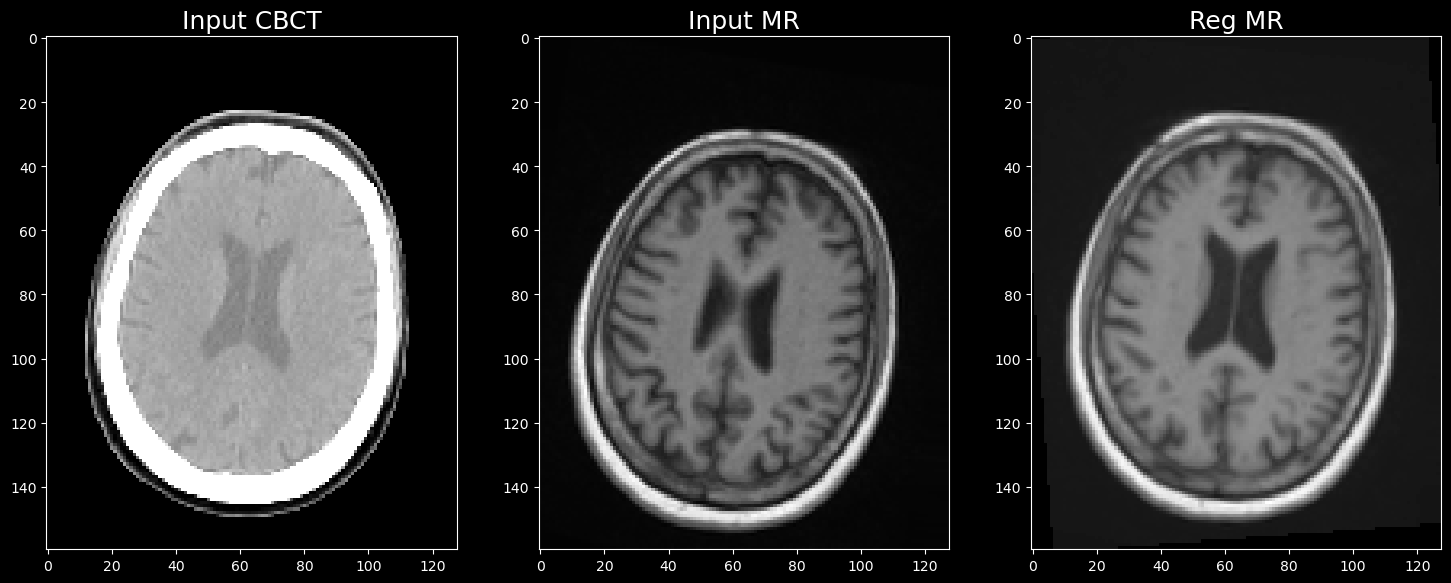

In [9]:
from scipy.ndimage.interpolation import affine_transform
from helpers import normalizeImage, random_transform, compute_negative_jacobian
# Create rigid deformation
T = random_transform(list((128,160,128)), 5, 5)
test_rigid_mr = affine_transform(moving_truth, T, mode='nearest')
test_cbct = fixed_img

# Convert data type and register
input_cbct = sitk.GetImageFromArray(test_cbct)
input_mr = sitk.GetImageFromArray(test_rigid_mr)
new_pic, _ = registration(input_cbct,input_mr)
input_cbct = sitk.GetArrayFromImage(input_cbct)

# Plot the results
input_mr = sitk.GetArrayFromImage(input_mr)
new_pic  = sitk.GetArrayFromImage(new_pic)
islice = 72
fig, ax = plt.subplots(1,3,figsize = [18,12])
ax[0].imshow(test_cbct[:,:,islice].T, cmap='gray')
ax[0].set_title('Input CBCT',fontdict={'fontsize': 18})
ax[1].imshow(test_rigid_mr[:,:,islice].T, cmap='gray')
ax[1].set_title('Input MR',fontdict={'fontsize': 18})
ax[2].imshow(new_pic[:,:,islice].T, cmap='gray')
ax[2].set_title('Reg MR',fontdict={'fontsize': 18})
plt.show()

In [10]:
# Path
ori_path = '/home/myi16/jsr_Y/new_data'
write_path = '/home/myi16/jsr_Y/new_flow'

# For each data
for i in tqdm(range(400)):
    name = f"/new_{i:03}.npz"
    data = np.load(ori_path+name,allow_pickle=True)
    fixed_img,moving_img,fixed_warp,moving_truth,ventricle_fixed,ventricle_moving,affine,flow,cbct,cbct_warp = dataread(data)
    # register mr
    input_cbct = sitk.GetImageFromArray(cbct)
    input_mr = sitk.GetImageFromArray(moving_img)
    new_pic, Tx = registration(input_cbct, input_mr)
    # register segmentation maps
    segmap_pre = sitk.GetImageFromArray(ventricle_moving)
    segmap_post = sitk.Resample(segmap_pre, Tx,interpolator=sitk.sitkNearestNeighbor)
    segmap_post = sitk.GetArrayFromImage(segmap_post)
    
    #input_cbct = sitk.GetArrayFromImage(input_cbct)
    #input_mr = sitk.GetArrayFromImage(input_mr)
    new_pic = sitk.GetArrayFromImage(new_pic)
    
    np.savez(os.path.join(write_path, f"{i:03}.npz"),
            fixed_img=fixed_img, moving_img=new_pic, fixed_warp=fixed_warp,
            moving_truth=moving_truth, ventricle_fixed=ventricle_fixed, ventricle_moving=segmap_post,
            affine=affine, flow=flow, sources=data['sources'],
            cbct=cbct, cbct_warp=cbct_warp, index=data['index'])
    

100%|██████████| 400/400 [2:39:31<00:00, 23.93s/it]  


Text(0.5, 0, 'Malpen segmentation(deformed)')

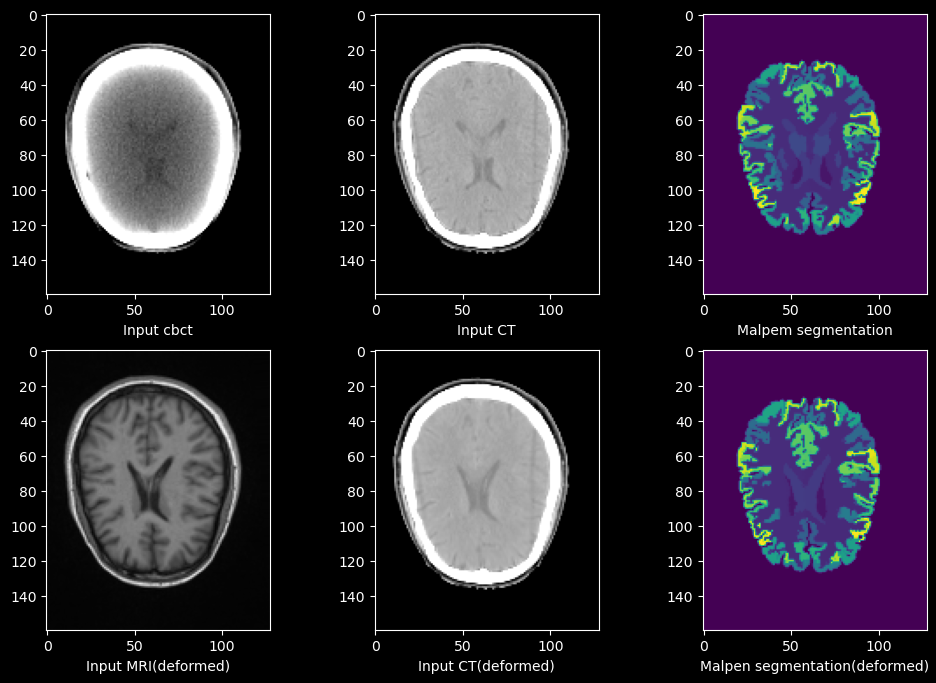

In [11]:
fig, ax = plt.subplots(2,3,figsize=(12,8))
ax[0][0].imshow(cbct[:,:,72].T, cmap='gray')
ax[0][0].set_xlabel('Input cbct')
ax[1][0].imshow(moving_img[:,:,72].T, cmap='gray')
ax[1][0].set_xlabel('Input MRI(deformed)')

ax[0][1].imshow(fixed_img[:,:,72].T, cmap='gray')
ax[0][1].set_xlabel('Input CT')
ax[1][1].imshow(fixed_warp[:,:,72].T, cmap='gray')
ax[1][1].set_xlabel('Input CT(deformed)')

ax[0][2].imshow(ventricle_fixed[:,:,72].T)
ax[0][2].set_xlabel('Malpem segmentation')
ax[1][2].imshow(segmap_post[:,:,72].T)
ax[1][2].set_xlabel('Malpen segmentation(deformed)')